# Summary

Sneaker Name is ' Yeezy - Adidas-Yeezy-Boost-350-V2-Blue-Tint'
    - Accuracy dropped even further after limiting dataset to shoe size 10 (best R2 0.5797)
        - Previously best R2 0.8032 for dtaaset with shoe sizes 9, 10, and 11
    - Extra Trees best for 7-day prediction
    - CatBoost best for 30-day prediction
    - TheilSen Net best for 90-day prediction

# Data Processing and EDA

In [1]:
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from datetime import datetime
from datetime import timedelta
from cycler import cycler

In [2]:
plt.style.use('ggplot')
plt.rcParams['axes.labelsize'] = 22
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['figure.titlesize'] = 26
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['legend.title_fontsize'] = 20
mpl.rcParams['lines.linewidth'] = 3
#mpl.rcParams['axes.prop_cycle'] = color=['#CF353C', 'FFE3A6', '#727272']

In [3]:
#from cycler import cycler
#plt.style.use('dark_background')
#plt.style.use('dark_background')
#mpl.rcParams['axes.prop_cycle'] = cycler(color=['teal', 'magenta', 'yellow'])

In [4]:
CUTOFF_TRAINMIN = '2018-01-01'
CUTOFF_TRAINVAL = '2018-11-15'
#yeezy Jan 1, 2018
#john jun 1, 2018

df = pd.read_excel('StockX-Data-Contest-2019-3.xlsx', sheet_name='Raw Data')
df['Sneaker Name'] = df['Brand'] + ' - ' + df['Sneaker Name']
df['DaysStored'] = pd.Series(df['Order Date'] - df['Release Date']).apply(lambda x: x.days)
df = df[['Order Date', 'Sneaker Name', 'Shoe Size', 'Sale Price', 'DaysStored']]
df

,Order Date,Sneaker Name,Shoe Size,Sale Price,DaysStored
0,2017-09-01,Yeezy - Adidas-Yeezy-Boost-350-Low-V2-Beluga,11.0,1097.0,342
1,2017-09-01,Yeezy - Adidas-Yeezy-Boost-350-V2-Core-Black-...,11.0,685.0,282
2,2017-09-01,Yeezy - Adidas-Yeezy-Boost-350-V2-Core-Black-...,11.0,690.0,282
3,2017-09-01,Yeezy - Adidas-Yeezy-Boost-350-V2-Core-Black-Red,11.5,1075.0,282
4,2017-09-01,Yeezy - Adidas-Yeezy-Boost-350-V2-Core-Black-...,11.0,828.0,202
...,...,...,...,...,...
99951,2019-02-13,Yeezy - adidas-Yeezy-Boost-350-V2-Static-Refl...,8.0,565.0,49
99952,2019-02-13,Yeezy - adidas-Yeezy-Boost-350-V2-Static-Refl...,8.5,598.0,49
99953,2019-02-13,Yeezy - adidas-Yeezy-Boost-350-V2-Static-Refl...,5.5,605.0,49
99954,2019-02-13,Yeezy - adidas-Yeezy-Boost-350-V2-Static-Refl...,11.0,650.0,49


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99956 entries, 0 to 99955
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Order Date    99956 non-null  datetime64[ns]
 1   Sneaker Name  99956 non-null  object        
 2   Shoe Size     99956 non-null  float64       
 3   Sale Price    99956 non-null  float64       
 4   DaysStored    99956 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 3.8+ MB


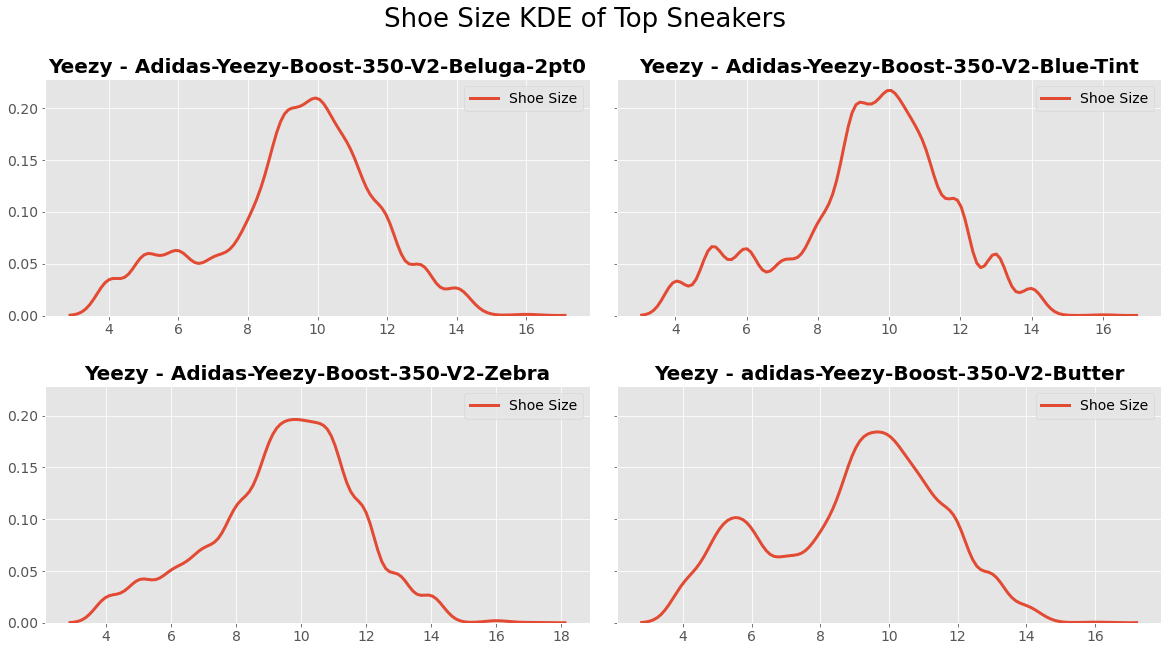

In [6]:
top_sneakers = df.groupby(['Sneaker Name', 'Shoe Size']).size().reset_index().nlargest(9, 0)['Sneaker Name'].to_list()
top_sneakers = sorted(list(set(top_sneakers)))

fig, ax = plt.subplots(2, 2, figsize=(20,10), sharey = True)
fig.subplots_adjust(hspace=0.3, wspace=0.05)
fig.suptitle('Shoe Size KDE of Top Sneakers')

x, y = 0, 0
for i in range(0, len(top_sneakers)):
    x, y = int(i/2), i % 2
    sns.kdeplot(data=df[df['Sneaker Name']==top_sneakers[i]]['Shoe Size'], ax=ax[x][y])
    ax[x][y].set_title(top_sneakers[i].strip(), fontsize=20)

## Filter to single Sneaker Name

In [7]:
top_sneakers

[' Yeezy - Adidas-Yeezy-Boost-350-V2-Beluga-2pt0',
 ' Yeezy - Adidas-Yeezy-Boost-350-V2-Blue-Tint',
 ' Yeezy - Adidas-Yeezy-Boost-350-V2-Zebra',
 ' Yeezy - adidas-Yeezy-Boost-350-V2-Butter']

In [8]:
sneaker_name = ' Yeezy - Adidas-Yeezy-Boost-350-V2-Blue-Tint'
df_agg = df[(df['Sneaker Name']==sneaker_name) & \
            (df['Shoe Size'].isin([10]))].copy()
df_agg = df_agg.groupby(['Order Date', 'Sneaker Name', 'Shoe Size']).mean().reset_index()
df_agg

,Order Date,Sneaker Name,Shoe Size,Sale Price,DaysStored
0,2017-12-13,Yeezy - Adidas-Yeezy-Boost-350-V2-Blue-Tint,10.0,448.500000,-3
1,2017-12-14,Yeezy - Adidas-Yeezy-Boost-350-V2-Blue-Tint,10.0,396.000000,-2
2,2017-12-15,Yeezy - Adidas-Yeezy-Boost-350-V2-Blue-Tint,10.0,366.785714,-1
3,2017-12-16,Yeezy - Adidas-Yeezy-Boost-350-V2-Blue-Tint,10.0,379.837209,0
4,2017-12-17,Yeezy - Adidas-Yeezy-Boost-350-V2-Blue-Tint,10.0,387.578947,1
...,...,...,...,...,...
315,2019-02-05,Yeezy - Adidas-Yeezy-Boost-350-V2-Blue-Tint,10.0,349.000000,416
316,2019-02-07,Yeezy - Adidas-Yeezy-Boost-350-V2-Blue-Tint,10.0,339.500000,418
317,2019-02-09,Yeezy - Adidas-Yeezy-Boost-350-V2-Blue-Tint,10.0,362.000000,420
318,2019-02-10,Yeezy - Adidas-Yeezy-Boost-350-V2-Blue-Tint,10.0,363.333333,421


In [9]:
#start_dt = df_agg['Order Date'].min()
start_dt = datetime.strptime(CUTOFF_TRAINMIN, '%Y-%m-%d')
end_dt = df_agg['Order Date'].max()

df_cal = pd.DataFrame({'dt': pd.date_range(start_dt, end_dt)})
df_cal['dt_str'] = df_cal['dt'].apply(lambda x: x.strftime('%Y-%m-%d'))

df_cal['lst_lb15'] = df_cal['dt'].apply(lambda x: pd.date_range(x, x + timedelta(15 - 1)).strftime('%Y-%m-%d').to_list())
df_cal['lst_lb30'] = df_cal['dt'].apply(lambda x: pd.date_range(x, x + timedelta(30 - 1)).strftime('%Y-%m-%d').to_list())
df_cal['lst_lb60'] = df_cal['dt'].apply(lambda x: pd.date_range(x, x + timedelta(60 - 1)).strftime('%Y-%m-%d').to_list())
df_cal['lst_lb180'] = df_cal['dt'].apply(lambda x: pd.date_range(x, x + timedelta(180 - 1)).strftime('%Y-%m-%d').to_list())

df_cal['lb15_last'] = df_cal['dt'].apply(lambda x: (x + timedelta(15 - 1)).strftime('%Y-%m-%d'))
df_cal['lb30_last'] = df_cal['dt'].apply(lambda x: (x + timedelta(30 - 1)).strftime('%Y-%m-%d'))
df_cal['lb60_last'] = df_cal['dt'].apply(lambda x: (x + timedelta(60 - 1)).strftime('%Y-%m-%d'))
df_cal['lb180_last'] = df_cal['dt'].apply(lambda x: (x + timedelta(180 - 1)).strftime('%Y-%m-%d'))

df_cal['lb15_plus7'] = df_cal['dt'].apply(lambda x: (x + timedelta(22)).strftime('%Y-%m-%d'))
df_cal['lb30_plus7'] = df_cal['dt'].apply(lambda x: (x + timedelta(37)).strftime('%Y-%m-%d'))
df_cal['lb60_plus7'] = df_cal['dt'].apply(lambda x: (x + timedelta(67)).strftime('%Y-%m-%d'))

df_cal['lb60_plus30'] = df_cal['dt'].apply(lambda x: (x + timedelta(90)).strftime('%Y-%m-%d'))
df_cal['lb180_plus90'] = df_cal['dt'].apply(lambda x: (x + timedelta(270)).strftime('%Y-%m-%d'))


print(df_cal.shape, df_cal.columns)
df_cal.head(5)

(407, 15) Index(['dt', 'dt_str', 'lst_lb15', 'lst_lb30', 'lst_lb60', 'lst_lb180',
       'lb15_last', 'lb30_last', 'lb60_last', 'lb180_last', 'lb15_plus7',
       'lb30_plus7', 'lb60_plus7', 'lb60_plus30', 'lb180_plus90'],
      dtype='object')


,dt,dt_str,lst_lb15,lst_lb30,lst_lb60,lst_lb180,lb15_last,lb30_last,lb60_last,lb180_last,lb15_plus7,lb30_plus7,lb60_plus7,lb60_plus30,lb180_plus90
0,2018-01-01,2018-01-01,"[2018-01-01, 2018-01-02, 2018-01-03, 2018-01-0...","[2018-01-01, 2018-01-02, 2018-01-03, 2018-01-0...","[2018-01-01, 2018-01-02, 2018-01-03, 2018-01-0...","[2018-01-01, 2018-01-02, 2018-01-03, 2018-01-0...",2018-01-15,2018-01-30,2018-03-01,2018-06-29,2018-01-23,2018-02-07,2018-03-09,2018-04-01,2018-09-28
1,2018-01-02,2018-01-02,"[2018-01-02, 2018-01-03, 2018-01-04, 2018-01-0...","[2018-01-02, 2018-01-03, 2018-01-04, 2018-01-0...","[2018-01-02, 2018-01-03, 2018-01-04, 2018-01-0...","[2018-01-02, 2018-01-03, 2018-01-04, 2018-01-0...",2018-01-16,2018-01-31,2018-03-02,2018-06-30,2018-01-24,2018-02-08,2018-03-10,2018-04-02,2018-09-29
2,2018-01-03,2018-01-03,"[2018-01-03, 2018-01-04, 2018-01-05, 2018-01-0...","[2018-01-03, 2018-01-04, 2018-01-05, 2018-01-0...","[2018-01-03, 2018-01-04, 2018-01-05, 2018-01-0...","[2018-01-03, 2018-01-04, 2018-01-05, 2018-01-0...",2018-01-17,2018-02-01,2018-03-03,2018-07-01,2018-01-25,2018-02-09,2018-03-11,2018-04-03,2018-09-30
3,2018-01-04,2018-01-04,"[2018-01-04, 2018-01-05, 2018-01-06, 2018-01-0...","[2018-01-04, 2018-01-05, 2018-01-06, 2018-01-0...","[2018-01-04, 2018-01-05, 2018-01-06, 2018-01-0...","[2018-01-04, 2018-01-05, 2018-01-06, 2018-01-0...",2018-01-18,2018-02-02,2018-03-04,2018-07-02,2018-01-26,2018-02-10,2018-03-12,2018-04-04,2018-10-01
4,2018-01-05,2018-01-05,"[2018-01-05, 2018-01-06, 2018-01-07, 2018-01-0...","[2018-01-05, 2018-01-06, 2018-01-07, 2018-01-0...","[2018-01-05, 2018-01-06, 2018-01-07, 2018-01-0...","[2018-01-05, 2018-01-06, 2018-01-07, 2018-01-0...",2018-01-19,2018-02-03,2018-03-05,2018-07-03,2018-01-27,2018-02-11,2018-03-13,2018-04-05,2018-10-02


In [10]:
df_tmp = df_cal[['dt', 'dt_str']].copy()
df_tmp['key'] = 0
print('df_tmp.shape', df_tmp.shape)

df_tmp = df_tmp.merge(pd.DataFrame({'key': [0], 'Sneaker Name': [sneaker_name]}), how='outer')
df_tmp = df_tmp.merge(pd.DataFrame({'key': [0], 'Shoe Size': [10]}), how='outer')
df_tmp = df_tmp.merge(df_agg, how='left', left_on=['dt', 'Sneaker Name', 'Shoe Size'], right_on=['Order Date', 'Sneaker Name', 'Shoe Size'])
df_tmp = df_tmp[['dt_str', 'Sneaker Name', 'Shoe Size', 'Sale Price', 'DaysStored']]
print('df_tmp.shape', df_tmp.shape)
df_tmp.head(5)

df_tmp.shape (407, 3)
df_tmp.shape (407, 5)


,dt_str,Sneaker Name,Shoe Size,Sale Price,DaysStored
0,2018-01-01,Yeezy - Adidas-Yeezy-Boost-350-V2-Blue-Tint,10,353.888889,16.0
1,2018-01-02,Yeezy - Adidas-Yeezy-Boost-350-V2-Blue-Tint,10,351.812500,17.0
2,2018-01-03,Yeezy - Adidas-Yeezy-Boost-350-V2-Blue-Tint,10,348.600000,18.0
3,2018-01-04,Yeezy - Adidas-Yeezy-Boost-350-V2-Blue-Tint,10,348.166667,19.0
4,2018-01-05,Yeezy - Adidas-Yeezy-Boost-350-V2-Blue-Tint,10,348.285714,20.0


In [11]:
pvt_price = df_tmp[['dt_str', 'Shoe Size', 'Sale Price']].copy()
pvt_price = pvt_price.pivot(index='Shoe Size', columns='dt_str', values='Sale Price')
pvt_price = pvt_price.interpolate(method='pad', axis=0, limit_direction='forward')
print('pvt_price.shape', pvt_price.shape)

pvt_price_diff = pvt_price.diff(axis=1)
pvt_price_diff = pvt_price_diff.reset_index()
pvt_price = pvt_price.reset_index()
print(pvt_price['Shoe Size'])

pvt_store = df_tmp[['dt_str', 'Shoe Size', 'DaysStored']].copy()
pvt_store = pvt_store.pivot(index='Shoe Size', columns='dt_str', values='DaysStored')
pvt_store = pvt_store.interpolate(method='linear', axis=0, limit_direction='both')
pvt_store = pvt_store.interpolate(method='linear', axis=1, limit_direction='both')  # fill remaining nulls
print('pvt_store.shape', pvt_store.shape)
pvt_store = pvt_store.reset_index()
print(pvt_store['Shoe Size'])

pvt_price.shape (1, 407)
0    10
Name: Shoe Size, dtype: int64
pvt_store.shape (1, 407)
0    10
Name: Shoe Size, dtype: int64


In [12]:
pvt_price

dt_str,Shoe Size,2018-01-01,2018-01-02,2018-01-03,2018-01-04,2018-01-05,2018-01-06,2018-01-07,2018-01-08,2018-01-09,...,2019-02-02,2019-02-03,2019-02-04,2019-02-05,2019-02-06,2019-02-07,2019-02-08,2019-02-09,2019-02-10,2019-02-11
0,10,353.888889,351.8125,348.6,348.166667,348.285714,349.0,347.625,348.25,345.8,...,353.5,353.5,337.5,349.0,349.0,339.5,339.5,362.0,363.333333,381.0


In [13]:
pvt_price_diff

dt_str,Shoe Size,2018-01-01,2018-01-02,2018-01-03,2018-01-04,2018-01-05,2018-01-06,2018-01-07,2018-01-08,2018-01-09,...,2019-02-02,2019-02-03,2019-02-04,2019-02-05,2019-02-06,2019-02-07,2019-02-08,2019-02-09,2019-02-10,2019-02-11
0,10,NaN,-2.076389,-3.2125,-0.433333,0.119048,0.714286,-1.375,0.625,-2.45,...,0.0,0.0,-16.0,11.5,0.0,-9.5,0.0,22.5,1.333333,17.666667


In [14]:
df_results = pd.DataFrame({'scenario': pd.Series([], dtype=str),
                           'model': pd.Series([], dtype=str),
                           'MAE': pd.Series([], dtype=np.half),
                           'MSE': pd.Series([], dtype=np.half),
                           'RMSE': pd.Series([], dtype=np.half),
                           'R2': pd.Series([], dtype=np.half),
                           'RMSLE': pd.Series([], dtype=np.half),
                           'MAPE': pd.Series([], dtype=np.half)})
df_results

,scenario,model,MAE,MSE,RMSE,R2,RMSLE,MAPE


# Regression

In [15]:
import pycaret.regression as py15
import pycaret.regression as py60
import pycaret.regression as py180
from pycaret.utils import check_metric

## Models List

In [16]:
py15.models()

,Name,Reference,Turbo
ID,,,
lr,Linear Regression,sklearn.linear_model.LinearRegression,True
lasso,Lasso Regression,sklearn.linear_model.Lasso,True
ridge,Ridge Regression,sklearn.linear_model.Ridge,True
en,Elastic Net,sklearn.linear_model.ElasticNet,True
lar,Least Angle Regression,sklearn.linear_model.Lars,True
llar,Lasso Least Angle Regression,sklearn.linear_model.LassoLars,True
omp,Orthogonal Matching Pursuit,sklearn.linear_model.OMP,True
br,Bayesian Ridge,sklearn.linear_model.BayesianRidge,True
ard,Automatic Relevance Determination,sklearn.linear_model.ARDRegression,False


## Price (As Is), Days Stored (First Order, Predict)

### 7-Day Prediction

#### Load Train and Test Data

In [17]:
train_win15 = df_cal[(df_cal['lb15_plus7'] < CUTOFF_TRAINVAL)][['dt_str', 'lst_lb15', 'lb15_plus7']]
train_win15['label'] = train_win15['lb15_plus7'].apply(lambda x: pvt_price[['Shoe Size']])
train_win15['target'] = train_win15['lb15_plus7'].apply(lambda x: pd.DataFrame({'target': pvt_price[x]}))
train_win15['store_frd'] = train_win15['dt_str'].apply(lambda x: pd.DataFrame({'store_frd': pvt_store[x]}))
train_win15['store_prd'] = train_win15['lb15_plus7'].apply(lambda x: pd.DataFrame({'store_prd': pvt_store[x]}))
train_win15['feature'] = train_win15['lst_lb15'].apply(lambda x: pvt_price[x])
for row in train_win15['feature']:
    row.columns = np.arange(1, len(row.columns) + 1)

label15 = pd.concat(train_win15['label'].to_list(), axis=0)
label15 = pd.get_dummies(label15['Shoe Size'], prefix='shoe_size')
target15 = pd.concat(train_win15['target'].to_list(), axis=0)
store15_frd = pd.concat(train_win15['store_frd'].to_list(), axis=0)
store15_prd = pd.concat(train_win15['store_prd'].to_list(), axis=0)
feature15 = pd.concat(train_win15['feature'].to_list(), axis=0)

train_win15 = pd.concat([label15, target15, store15_frd, store15_prd, feature15], axis=1)
print(train_win15.shape, train_win15.columns)
train_win15.head(5)

(296, 19) Index(['shoe_size_10',       'target',    'store_frd',    'store_prd',
                    1,              2,              3,              4,
                    5,              6,              7,              8,
                    9,             10,             11,             12,
                   13,             14,             15],
      dtype='object')


,shoe_size_10,target,store_frd,store_prd,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,1,359.875000,16.0,38.0,353.888889,351.812500,348.600000,348.166667,348.285714,349.000,347.625000,348.250000,345.800000,351.750000,350.666667,348.000000,349.000000,352.000000,349.500000
0,1,355.000000,17.0,39.0,351.812500,348.600000,348.166667,348.285714,349.000000,347.625,348.250000,345.800000,351.750000,350.666667,348.000000,349.000000,352.000000,349.500000,346.666667
0,1,357.909091,18.0,40.0,348.600000,348.166667,348.285714,349.000000,347.625000,348.250,345.800000,351.750000,350.666667,348.000000,349.000000,352.000000,349.500000,346.666667,349.571429
0,1,345.000000,19.0,41.0,348.166667,348.285714,349.000000,347.625000,348.250000,345.800,351.750000,350.666667,348.000000,349.000000,352.000000,349.500000,346.666667,349.571429,350.000000
0,1,357.250000,20.0,42.0,348.285714,349.000000,347.625000,348.250000,345.800000,351.750,350.666667,348.000000,349.000000,352.000000,349.500000,346.666667,349.571429,350.000000,353.111111


In [18]:
test_win15 = df_cal[(df_cal['lb15_plus7'] >= CUTOFF_TRAINVAL) &
                    (df_cal['lb15_plus7'] < end_dt.strftime('%Y-%m-%d')) ][['dt_str', 'lst_lb15', 'lb15_plus7']]
test_win15['label'] = test_win15['lb15_plus7'].apply(lambda x: pvt_price[['Shoe Size']])
test_win15['target'] = test_win15['lb15_plus7'].apply(lambda x: pd.DataFrame({'target': pvt_price[x]}))
test_win15['store_frd'] = test_win15['dt_str'].apply(lambda x: pd.DataFrame({'store_frd': pvt_store[x]}))
test_win15['store_prd'] = test_win15['lb15_plus7'].apply(lambda x: pd.DataFrame({'store_prd': pvt_store[x]}))
test_win15['feature'] = test_win15['lst_lb15'].apply(lambda x: pvt_price[x])
for row in test_win15['feature']:
    row.columns = np.arange(1, len(row.columns) + 1)

label15 = pd.concat(test_win15['label'].to_list(), axis=0)
label15 = pd.get_dummies(label15['Shoe Size'], prefix='shoe_size')
target15 = pd.concat(test_win15['target'].to_list(), axis=0)
store15_frd = pd.concat(test_win15['store_frd'].to_list(), axis=0)
store15_prd = pd.concat(test_win15['store_prd'].to_list(), axis=0)
feature15 = pd.concat(test_win15['feature'].to_list(), axis=0)

test_win15 = pd.concat([label15, target15, store15_frd, store15_prd, feature15], axis=1)
print(test_win15.shape, test_win15.columns)
test_win15.head(5)

(88, 19) Index(['shoe_size_10',       'target',    'store_frd',    'store_prd',
                    1,              2,              3,              4,
                    5,              6,              7,              8,
                    9,             10,             11,             12,
                   13,             14,             15],
      dtype='object')


,shoe_size_10,target,store_frd,store_prd,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,1,338.0,312.0,334.0,363.5,363.5,370.0,351.0,351.0,351.0,351.0,326.0,320.0,325.0,325.0,335.0,360.0,360.0,360.0
0,1,338.0,313.0,335.0,363.5,370.0,351.0,351.0,351.0,351.0,326.0,320.0,325.0,325.0,335.0,360.0,360.0,360.0,360.0
0,1,338.0,314.0,336.0,370.0,351.0,351.0,351.0,351.0,326.0,320.0,325.0,325.0,335.0,360.0,360.0,360.0,360.0,359.0
0,1,338.0,315.0,337.0,351.0,351.0,351.0,351.0,326.0,320.0,325.0,325.0,335.0,360.0,360.0,360.0,360.0,359.0,364.0
0,1,338.0,316.0,338.0,351.0,351.0,351.0,326.0,320.0,325.0,325.0,335.0,360.0,360.0,360.0,360.0,359.0,364.0,364.0


In [19]:
ret = py15.setup(data=train_win15, target='target', train_size=0.80, session_id=123, silent=True)

 
Setup Succesfully Completed.


,Description,Value
0,session_id,123
1,Transform Target,False
2,Transform Target Method,None
3,Original Data,"(296, 19)"
4,Missing Values,False
5,Numeric Features,18
6,Categorical Features,0
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


#### Compare Models

In [20]:
py15.compare_models(sort='R2')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
0,Extra Trees Regressor,6.4392,70.4273,8.3143,0.5797,0.0223,0.0172,0.1399
1,CatBoost Regressor,6.5738,74.7030,8.5578,0.5629,0.0230,0.0176,1.5758
2,Random Forest,6.5726,78.0726,8.7251,0.5379,0.0235,0.0176,0.1419
3,K Neighbors Regressor,6.9212,86.2827,9.1003,0.5242,0.0245,0.0185,0.0023
4,AdaBoost Regressor,6.9722,85.1334,9.1310,0.5007,0.0245,0.0186,0.0645
5,Gradient Boosting Regressor,7.1450,87.5182,9.2566,0.4797,0.0249,0.0191,0.0704
6,Bayesian Ridge,7.1893,93.0520,9.4551,0.4665,0.0255,0.0193,0.0034
7,Lasso Regression,7.1783,93.9622,9.4892,0.4612,0.0256,0.0193,0.0039
8,Light Gradient Boosting Machine,7.2229,90.4815,9.4070,0.4574,0.0252,0.0193,0.0280
9,Extreme Gradient Boosting,7.1069,93.1710,9.4492,0.4565,0.0254,0.0190,0.1501


ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=-1, oob_score=False,
                    random_state=123, verbose=0, warm_start=False)

In [21]:
py15.compare_models(sort='RMSE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
0,Extra Trees Regressor,6.4392,70.4273,8.3143,0.5797,0.0223,0.0172,0.1396
1,CatBoost Regressor,6.5738,74.7030,8.5578,0.5629,0.0230,0.0176,1.8669
2,Random Forest,6.5726,78.0726,8.7251,0.5379,0.0235,0.0176,0.1652
3,K Neighbors Regressor,6.9212,86.2827,9.1003,0.5242,0.0245,0.0185,0.0026
4,AdaBoost Regressor,6.9722,85.1334,9.1310,0.5007,0.0245,0.0186,0.0654
5,Gradient Boosting Regressor,7.1450,87.5182,9.2566,0.4797,0.0249,0.0191,0.0702
6,Light Gradient Boosting Machine,7.2229,90.4815,9.4070,0.4574,0.0252,0.0193,0.0369
7,Extreme Gradient Boosting,7.1069,93.1710,9.4492,0.4565,0.0254,0.0190,0.0631
8,Bayesian Ridge,7.1893,93.0520,9.4551,0.4665,0.0255,0.0193,0.0052
9,Lasso Regression,7.1783,93.9622,9.4892,0.4612,0.0256,0.0193,0.0037


ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=-1, oob_score=False,
                    random_state=123, verbose=0, warm_start=False)

#### Extra Trees - MAE 6.4392, RMSE 8.3143, R2 0.5797

In [22]:
et15 = py15.create_model('et')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,7.7327,112.6374,10.6131,0.3680,0.0285,0.0208
1,7.1309,82.5591,9.0862,0.6443,0.0247,0.0192
2,6.5369,57.9970,7.6156,0.5841,0.0198,0.0170
3,6.4862,89.8920,9.4811,0.6383,0.0267,0.0180
4,6.9383,67.9481,8.2431,0.3633,0.0217,0.0183
5,6.3669,65.5553,8.0966,0.5101,0.0214,0.0168
6,5.8667,56.8268,7.5384,0.7838,0.0206,0.0159
7,6.2243,70.9792,8.4249,0.4870,0.0221,0.0162
8,6.1677,61.0786,7.8153,0.7183,0.0215,0.0167
9,4.9413,38.7994,6.2289,0.6995,0.0162,0.0129


In [23]:
tuned_et15 = py15.tune_model(et15, optimize='RMSE', choose_better=True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,7.6619,108.7287,10.4273,0.3899,0.0280,0.0207
1,7.1775,84.5064,9.1927,0.6360,0.0250,0.0194
2,6.9128,62.8875,7.9302,0.5490,0.0206,0.0180
3,6.7271,115.7904,10.7606,0.5341,0.0304,0.0187
4,6.8171,67.6668,8.2260,0.3660,0.0216,0.0180
5,6.4446,64.8743,8.0545,0.5151,0.0213,0.0170
6,5.7025,54.5829,7.3880,0.7923,0.0202,0.0155
7,6.1480,64.4590,8.0286,0.5341,0.0210,0.0160
8,6.6717,89.0321,9.4357,0.5893,0.0264,0.0183
9,4.9501,40.2503,6.3443,0.6883,0.0165,0.0128


In [24]:
df_val15 = py15.predict_model(et15)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,6.8189,80.6073,8.9782,0.6329,0.0243,0.0184


In [25]:
df_test15 = py15.predict_model(et15, data=test_win15)
df_test15

,shoe_size_10,target,store_frd,store_prd,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,Label
0,1,338.000000,312.0,334.0,363.5,363.5,370.0,351.0,351.0,351.0,351.0,326.0,320.0,325.0,325.0,335.0,360.0,360.0,360.0,349.4619
1,1,338.000000,313.0,335.0,363.5,370.0,351.0,351.0,351.0,351.0,326.0,320.0,325.0,325.0,335.0,360.0,360.0,360.0,360.0,351.5723
2,1,338.000000,314.0,336.0,370.0,351.0,351.0,351.0,351.0,326.0,320.0,325.0,325.0,335.0,360.0,360.0,360.0,360.0,359.0,353.3360
3,1,338.000000,315.0,337.0,351.0,351.0,351.0,351.0,326.0,320.0,325.0,325.0,335.0,360.0,360.0,360.0,360.0,359.0,364.0,355.5970
4,1,338.000000,316.0,338.0,351.0,351.0,351.0,326.0,320.0,325.0,325.0,335.0,360.0,360.0,360.0,360.0,359.0,364.0,364.0,357.0308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,1,349.000000,395.0,417.0,361.0,347.0,347.0,360.0,360.0,365.0,365.0,365.0,347.0,347.0,347.0,347.0,344.0,344.0,347.5,361.1791
84,1,339.500000,396.0,418.0,347.0,347.0,360.0,360.0,365.0,365.0,365.0,347.0,347.0,347.0,347.0,344.0,344.0,347.5,347.5,360.5100
85,1,339.500000,397.0,419.0,347.0,360.0,360.0,365.0,365.0,365.0,347.0,347.0,347.0,347.0,344.0,344.0,347.5,347.5,338.0,362.3788
86,1,362.000000,398.0,420.0,360.0,360.0,365.0,365.0,365.0,347.0,347.0,347.0,347.0,344.0,344.0,347.5,347.5,338.0,353.5,357.8075


#### Extra Trees - Prediction MAE 12.17

In [26]:
check_metric(df_test15.target, df_test15.Label, 'MAE')

12.17

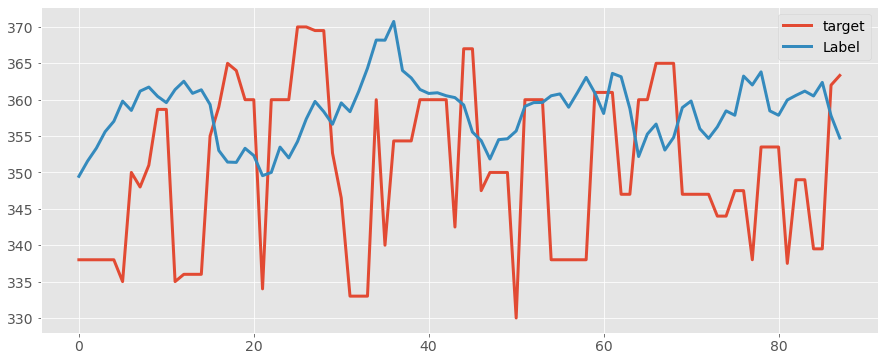

In [27]:
df_test15[df_test15['shoe_size_10']==1][['target','Label']].plot(figsize=(15,6));

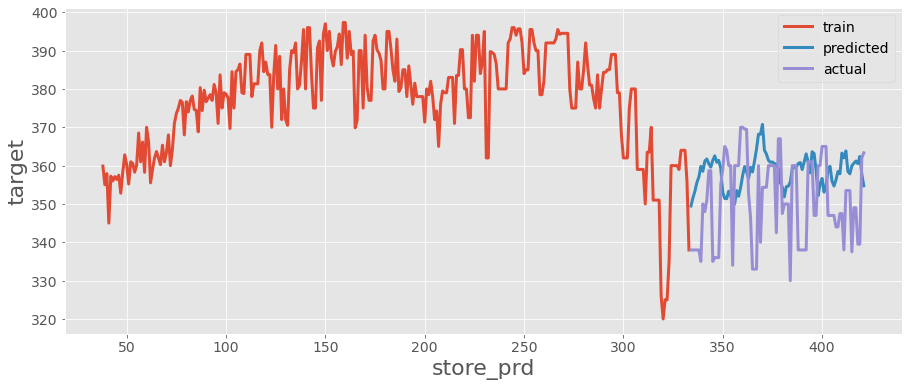

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(15,6))
ax = sns.lineplot(data=train_win15[train_win15['shoe_size_10']==1], x='store_prd', y='target', label='train', ax=ax)
ax = sns.lineplot(data=df_test15[df_test15['shoe_size_10']==1], x='store_prd', y='Label', label='predicted', ax=ax)
ax = sns.lineplot(data=df_test15[df_test15['shoe_size_10']==1], x='store_prd', y='target', label='actual', ax=ax);

### 30-Day Prediction

#### Load Train and Test Data

In [29]:
train_win60 = df_cal[(df_cal['lb60_plus30'] < CUTOFF_TRAINVAL)][['dt_str', 'lst_lb60', 'lb60_plus30']]
train_win60['label'] = train_win60['lb60_plus30'].apply(lambda x: pvt_price[['Shoe Size']])
train_win60['target'] = train_win60['lb60_plus30'].apply(lambda x: pd.DataFrame({'target': pvt_price[x]}))
train_win60['store_frd'] = train_win60['dt_str'].apply(lambda x: pd.DataFrame({'store_frd': pvt_store[x]}))
train_win60['store_prd'] = train_win60['lb60_plus30'].apply(lambda x: pd.DataFrame({'store_prd': pvt_store[x]}))
train_win60['feature'] = train_win60['lst_lb60'].apply(lambda x: pvt_price[x])
for row in train_win60['feature']:
    row.columns = np.arange(1, len(row.columns) + 1)

label60 = pd.concat(train_win60['label'].to_list(), axis=0)
label60 = pd.get_dummies(label60['Shoe Size'], prefix='shoe_size')
target60 = pd.concat(train_win60['target'].to_list(), axis=0)
store60_frd = pd.concat(train_win60['store_frd'].to_list(), axis=0)
store60_prd = pd.concat(train_win60['store_prd'].to_list(), axis=0)
feature60 = pd.concat(train_win60['feature'].to_list(), axis=0)

train_win60 = pd.concat([label60, target60, store60_frd, store60_prd, feature60], axis=1)
print(train_win60.shape, train_win60.columns)
train_win60.head(5)

(228, 64) Index(['shoe_size_10',       'target',    'store_frd',    'store_prd',
                    1,              2,              3,              4,
                    5,              6,              7,              8,
                    9,             10,             11,             12,
                   13,             14,             15,             16,
                   17,             18,             19,             20,
                   21,             22,             23,             24,
                   25,             26,             27,             28,
                   29,             30,             31,             32,
                   33,             34,             35,             36,
                   37,             38,             39,             40,
                   41,             42,             43,             44,
                   45,             46,             47,             48,
                   49,             50,             51,             

,shoe_size_10,target,store_frd,store_prd,1,2,3,4,5,6,...,51,52,53,54,55,56,57,58,59,60
0,1,385.0,16.0,106.0,353.888889,351.812500,348.600000,348.166667,348.285714,349.000,...,362.000000,360.250000,365.333333,361.0,363.4,368.0,360.0,364.2,371.0,373.6
0,1,386.5,17.0,107.0,351.812500,348.600000,348.166667,348.285714,349.000000,347.625,...,360.250000,365.333333,361.000000,363.4,368.0,360.0,364.2,371.0,373.6,375.0
0,1,379.0,18.0,108.0,348.600000,348.166667,348.285714,349.000000,347.625000,348.250,...,365.333333,361.000000,363.400000,368.0,360.0,364.2,371.0,373.6,375.0,377.0
0,1,378.8,19.0,109.0,348.166667,348.285714,349.000000,347.625000,348.250000,345.800,...,361.000000,363.400000,368.000000,360.0,364.2,371.0,373.6,375.0,377.0,376.5
0,1,389.0,20.0,110.0,348.285714,349.000000,347.625000,348.250000,345.800000,351.750,...,363.400000,368.000000,360.000000,364.2,371.0,373.6,375.0,377.0,376.5,368.0


In [30]:
test_win60 = df_cal[(df_cal['lb60_plus30'] >= CUTOFF_TRAINVAL) & (df_cal['lb60_plus30'] < end_dt.strftime('%Y-%m-%d')) ][['dt_str', 'lst_lb60', 'lb60_plus30']]
test_win60['label'] = test_win60['lb60_plus30'].apply(lambda x: pvt_price[['Shoe Size']])
test_win60['target'] = test_win60['lb60_plus30'].apply(lambda x: pd.DataFrame({'target': pvt_price[x]}))
test_win60['store_frd'] = test_win60['dt_str'].apply(lambda x: pd.DataFrame({'store_frd': pvt_store[x]}))
test_win60['store_prd'] = test_win60['lb60_plus30'].apply(lambda x: pd.DataFrame({'store_prd': pvt_store[x]}))
test_win60['feature'] = test_win60['lst_lb60'].apply(lambda x: pvt_price[x])
for row in test_win60['feature']:
    row.columns = np.arange(1, len(row.columns) + 1)

label60 = pd.concat(test_win60['label'].to_list(), axis=0)
label60 = pd.get_dummies(label60['Shoe Size'], prefix='shoe_size')
target60 = pd.concat(test_win60['target'].to_list(), axis=0)
store60_frd = pd.concat(test_win60['store_frd'].to_list(), axis=0)
store60_prd = pd.concat(test_win60['store_prd'].to_list(), axis=0)
feature60 = pd.concat(test_win60['feature'].to_list(), axis=0)

test_win60 = pd.concat([label60, target60, store60_frd, store60_prd, feature60], axis=1)
print(test_win60.shape, test_win60.columns)
test_win60.head(5)

(88, 64) Index(['shoe_size_10',       'target',    'store_frd',    'store_prd',
                    1,              2,              3,              4,
                    5,              6,              7,              8,
                    9,             10,             11,             12,
                   13,             14,             15,             16,
                   17,             18,             19,             20,
                   21,             22,             23,             24,
                   25,             26,             27,             28,
                   29,             30,             31,             32,
                   33,             34,             35,             36,
                   37,             38,             39,             40,
                   41,             42,             43,             44,
                   45,             46,             47,             48,
                   49,             50,             51,             5

,shoe_size_10,target,store_frd,store_prd,1,2,3,4,5,6,...,51,52,53,54,55,56,57,58,59,60
0,1,338.0,244.0,334.0,396.000000,396.000000,394.000000,395.666667,395.666667,392.0,...,389.0,389.0,389.0,379.0,379.0,368.0,362.0,362.0,362.0,375.0
0,1,338.0,245.0,335.0,396.000000,394.000000,395.666667,395.666667,392.000000,384.0,...,389.0,389.0,379.0,379.0,368.0,362.0,362.0,362.0,375.0,380.0
0,1,338.0,246.0,336.0,394.000000,395.666667,395.666667,392.000000,384.000000,385.0,...,389.0,379.0,379.0,368.0,362.0,362.0,362.0,375.0,380.0,380.0
0,1,338.0,247.0,337.0,395.666667,395.666667,392.000000,384.000000,385.000000,385.0,...,379.0,379.0,368.0,362.0,362.0,362.0,375.0,380.0,380.0,380.0
0,1,338.0,248.0,338.0,395.666667,392.000000,384.000000,385.000000,385.000000,395.5,...,379.0,368.0,362.0,362.0,362.0,375.0,380.0,380.0,380.0,359.0


In [31]:
ret = py60.setup(data=train_win60, target='target', train_size=0.80, session_id=123, silent=True)

 
Setup Succesfully Completed.


,Description,Value
0,session_id,123
1,Transform Target,False
2,Transform Target Method,None
3,Original Data,"(228, 64)"
4,Missing Values,False
5,Numeric Features,63
6,Categorical Features,0
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


#### Compare Models

In [32]:
py60.compare_models(sort='R2')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
0,CatBoost Regressor,7.2066,95.3052,9.5690,0.4363,0.0259,0.0194,3.8808
1,AdaBoost Regressor,7.4201,106.9164,9.9099,0.4243,0.0269,0.0200,0.1074
2,Extra Trees Regressor,7.4734,97.4329,9.7409,0.4028,0.0263,0.0200,0.1562
3,Gradient Boosting Regressor,7.8931,114.6071,10.4577,0.3441,0.0283,0.0212,0.1657
4,Random Forest,7.7794,115.4716,10.5040,0.3311,0.0285,0.0209,0.2465
5,Light Gradient Boosting Machine,7.7613,106.8289,10.1826,0.3307,0.0275,0.0208,0.0475
6,Extreme Gradient Boosting,8.8788,137.6418,11.4706,0.1961,0.0310,0.0238,0.0843
7,K Neighbors Regressor,8.0422,129.9745,11.2068,0.1784,0.0304,0.0216,0.0038
8,Bayesian Ridge,10.1619,183.1420,13.1981,0.0003,0.0357,0.0274,0.0074
9,Support Vector Machine,9.6679,197.7403,13.5103,-0.0076,0.0366,0.0263,0.0058


In [33]:
py60.compare_models(sort='RMSE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
0,CatBoost Regressor,7.2066,95.3052,9.5690,0.4363,0.0259,0.0194,4.5922
1,Extra Trees Regressor,7.4734,97.4329,9.7409,0.4028,0.0263,0.0200,0.3386
2,AdaBoost Regressor,7.4201,106.9164,9.9099,0.4243,0.0269,0.0200,0.3012
3,Light Gradient Boosting Machine,7.7613,106.8289,10.1826,0.3307,0.0275,0.0208,0.0645
4,Gradient Boosting Regressor,7.8931,114.6071,10.4577,0.3441,0.0283,0.0212,0.4166
5,Random Forest,7.7794,115.4716,10.5040,0.3311,0.0285,0.0209,0.2954
6,K Neighbors Regressor,8.0422,129.9745,11.2068,0.1784,0.0304,0.0216,0.0039
7,Extreme Gradient Boosting,8.8788,137.6418,11.4706,0.1961,0.0310,0.0238,0.4383
8,Bayesian Ridge,10.1619,183.1420,13.1981,0.0003,0.0357,0.0274,0.0086
9,Support Vector Machine,9.6679,197.7403,13.5103,-0.0076,0.0366,0.0263,0.0069


#### CatBoost - MAE 7.1496, RMSE 9.6017, R2 0.4147

In [34]:
catb60 = py60.create_model('catboost')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,7.2934,123.9894,11.1351,0.4378,0.0306,0.0200
1,6.7520,73.0940,8.5495,0.4820,0.0224,0.0177
2,7.7028,109.8110,10.4791,0.6293,0.0288,0.0209
3,6.5142,58.4779,7.6471,0.4610,0.0201,0.0171
4,6.9302,69.5108,8.3373,0.1178,0.0218,0.0181
5,5.7419,44.0531,6.6372,0.6779,0.0174,0.0151
6,8.1415,123.6089,11.1180,0.2496,0.0302,0.0218
7,7.2541,81.1084,9.0060,0.0753,0.0235,0.0188
8,9.1560,185.4410,13.6177,0.5318,0.0387,0.0259
9,6.5797,83.9577,9.1628,0.7002,0.0257,0.0182


In [35]:
tuned_catb60 = py60.tune_model(catb60, optimize='RMSE', choose_better=True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,7.5097,132.0140,11.4897,0.4014,0.0315,0.0205
1,6.4383,79.5478,8.9190,0.4362,0.0234,0.0168
2,7.3698,98.2276,9.9110,0.6684,0.0268,0.0199
3,6.9794,66.2651,8.1403,0.3893,0.0214,0.0183
4,6.1442,62.4609,7.9032,0.2073,0.0207,0.0160
5,5.8833,46.5094,6.8198,0.6599,0.0179,0.0155
6,7.6860,118.0027,10.8629,0.2837,0.0295,0.0206
7,8.2113,105.1292,10.2533,-0.1986,0.0268,0.0213
8,8.0073,144.8813,12.0367,0.6342,0.0342,0.0225
9,7.2665,93.7261,9.6812,0.6654,0.0262,0.0197


In [36]:
df_val60 = py60.predict_model(tuned_catb60)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,7.2197,84.3721,9.1854,0.3827,0.0244,0.0191


In [37]:
df_test60 = py60.predict_model(tuned_catb60, data=test_win60)
df_test60

,shoe_size_10,target,store_frd,store_prd,1,2,3,4,5,6,...,52,53,54,55,56,57,58,59,60,Label
0,1,338.000000,244.0,334.0,396.000000,396.000000,394.000000,395.666667,395.666667,392.0,...,389.0,389.0,379.0,379.0,368.0,362.0,362.0,362.0,375.0,374.4537
1,1,338.000000,245.0,335.0,396.000000,394.000000,395.666667,395.666667,392.000000,384.0,...,389.0,379.0,379.0,368.0,362.0,362.0,362.0,375.0,380.0,378.3123
2,1,338.000000,246.0,336.0,394.000000,395.666667,395.666667,392.000000,384.000000,385.0,...,379.0,379.0,368.0,362.0,362.0,362.0,375.0,380.0,380.0,377.7118
3,1,338.000000,247.0,337.0,395.666667,395.666667,392.000000,384.000000,385.000000,385.0,...,379.0,368.0,362.0,362.0,362.0,375.0,380.0,380.0,380.0,381.0910
4,1,338.000000,248.0,338.0,395.666667,392.000000,384.000000,385.000000,385.000000,395.5,...,368.0,362.0,362.0,362.0,375.0,380.0,380.0,380.0,359.0,379.3156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,1,349.000000,327.0,417.0,360.000000,359.000000,364.000000,364.000000,364.000000,356.0,...,367.0,367.0,347.5,350.0,350.0,350.0,330.0,360.0,360.0,383.4517
84,1,339.500000,328.0,418.0,359.000000,364.000000,364.000000,364.000000,356.000000,338.0,...,367.0,347.5,350.0,350.0,350.0,330.0,360.0,360.0,360.0,383.4302
85,1,339.500000,329.0,419.0,364.000000,364.000000,364.000000,356.000000,338.000000,338.0,...,347.5,350.0,350.0,350.0,330.0,360.0,360.0,360.0,338.0,383.8531
86,1,362.000000,330.0,420.0,364.000000,364.000000,356.000000,338.000000,338.000000,338.0,...,350.0,350.0,350.0,330.0,360.0,360.0,360.0,338.0,338.0,384.0205


#### CatBoost - Prediction MAE 33.5024

In [38]:
check_metric(df_test60.target, df_test60.Label, 'MAE')

33.5024

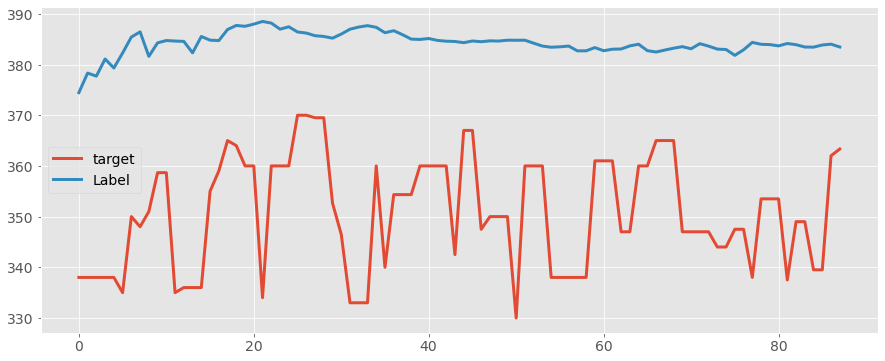

In [39]:
df_test60[df_test60['shoe_size_10']==1][['target','Label']].plot(figsize=(15,6));

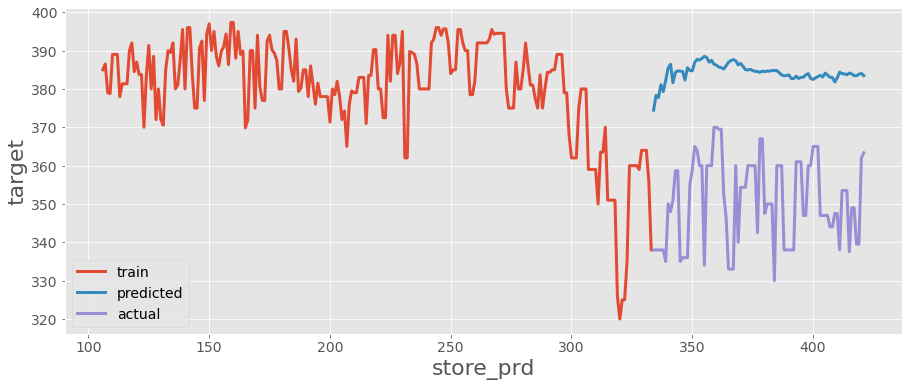

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(15,6))
ax = sns.lineplot(data=train_win60[train_win60['shoe_size_10']==1], x='store_prd', y='target', label='train', ax=ax)
ax = sns.lineplot(data=df_test60[df_test60['shoe_size_10']==1], x='store_prd', y='Label', label='predicted', ax=ax)
ax = sns.lineplot(data=df_test60[df_test60['shoe_size_10']==1], x='store_prd', y='target', label='actual', ax=ax);

#### Extra Trees - MAE 7.4734,  RMSE 9.7409, R2 0.4028

In [41]:
et60 = py60.create_model('et')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,7.9296,132.1283,11.4947,0.4009,0.0316,0.0218
1,7.2717,89.2642,9.4480,0.3674,0.0248,0.0190
2,7.3210,85.4843,9.2458,0.7114,0.0251,0.0197
3,6.8954,65.0636,8.0662,0.4003,0.0212,0.0181
4,6.7537,69.8925,8.3602,0.1130,0.0219,0.0176
5,6.3140,56.6076,7.5238,0.5861,0.0198,0.0166
6,8.8972,121.1821,11.0083,0.2644,0.0296,0.0235
7,7.3130,92.7527,9.6308,-0.0575,0.0251,0.0189
8,9.0347,169.7640,13.0294,0.5713,0.0370,0.0254
9,7.0040,92.1896,9.6015,0.6709,0.0268,0.0193


In [42]:
tuned_et60 = py60.tune_model(et60, optimize='RMSE', choose_better=True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,7.2014,117.7008,10.8490,0.4663,0.0299,0.0198
1,7.5495,95.1717,9.7556,0.3255,0.0257,0.0198
2,7.5970,101.2200,10.0608,0.6583,0.0276,0.0206
3,7.0817,65.4951,8.0929,0.3964,0.0213,0.0186
4,7.1083,71.9339,8.4814,0.0870,0.0222,0.0185
5,6.0949,50.7091,7.1210,0.6292,0.0187,0.0160
6,8.8201,124.8900,11.1754,0.2419,0.0301,0.0234
7,7.7604,93.3376,9.6611,-0.0642,0.0251,0.0201
8,9.6008,210.2689,14.5007,0.4691,0.0411,0.0271
9,7.5650,107.7204,10.3788,0.6154,0.0291,0.0209


In [43]:
df_val60 = py60.predict_model(et60)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,7.6636,90.8264,9.5303,0.3355,0.0253,0.0202


In [44]:
df_test60 = py60.predict_model(et60, data=test_win60)
df_test60

,shoe_size_10,target,store_frd,store_prd,1,2,3,4,5,6,...,52,53,54,55,56,57,58,59,60,Label
0,1,338.000000,244.0,334.0,396.000000,396.000000,394.000000,395.666667,395.666667,392.0,...,389.0,389.0,379.0,379.0,368.0,362.0,362.0,362.0,375.0,374.3771
1,1,338.000000,245.0,335.0,396.000000,394.000000,395.666667,395.666667,392.000000,384.0,...,389.0,379.0,379.0,368.0,362.0,362.0,362.0,375.0,380.0,378.3232
2,1,338.000000,246.0,336.0,394.000000,395.666667,395.666667,392.000000,384.000000,385.0,...,379.0,379.0,368.0,362.0,362.0,362.0,375.0,380.0,380.0,382.3263
3,1,338.000000,247.0,337.0,395.666667,395.666667,392.000000,384.000000,385.000000,385.0,...,379.0,368.0,362.0,362.0,362.0,375.0,380.0,380.0,380.0,379.9883
4,1,338.000000,248.0,338.0,395.666667,392.000000,384.000000,385.000000,385.000000,395.5,...,368.0,362.0,362.0,362.0,375.0,380.0,380.0,380.0,359.0,376.0812
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,1,349.000000,327.0,417.0,360.000000,359.000000,364.000000,364.000000,364.000000,356.0,...,367.0,367.0,347.5,350.0,350.0,350.0,330.0,360.0,360.0,378.8814
84,1,339.500000,328.0,418.0,359.000000,364.000000,364.000000,364.000000,356.000000,338.0,...,367.0,347.5,350.0,350.0,350.0,330.0,360.0,360.0,360.0,379.0937
85,1,339.500000,329.0,419.0,364.000000,364.000000,364.000000,356.000000,338.000000,338.0,...,347.5,350.0,350.0,350.0,330.0,360.0,360.0,360.0,338.0,379.0627
86,1,362.000000,330.0,420.0,364.000000,364.000000,356.000000,338.000000,338.000000,338.0,...,350.0,350.0,350.0,330.0,360.0,360.0,360.0,338.0,338.0,379.1946


#### Extra Trees - Prediction MAE 28.3236

In [45]:
check_metric(df_test60.target, df_test60.Label, 'MAE')

28.3236

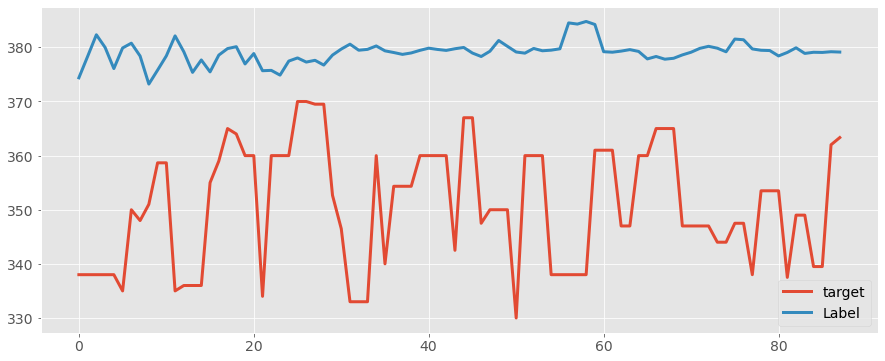

In [46]:
df_test60[df_test60['shoe_size_10']==1][['target','Label']].plot(figsize=(15,6));

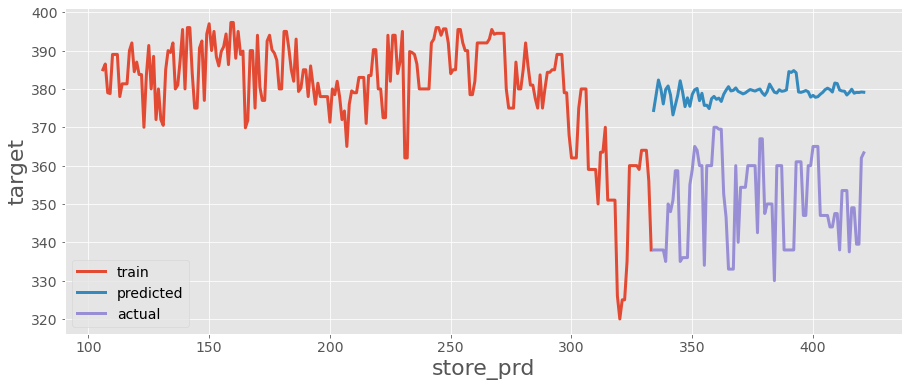

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(15,6))
ax = sns.lineplot(data=train_win60[train_win60['shoe_size_10']==1], x='store_prd', y='target', label='train', ax=ax)
ax = sns.lineplot(data=df_test60[df_test60['shoe_size_10']==1], x='store_prd', y='Label', label='predicted', ax=ax)
ax = sns.lineplot(data=df_test60[df_test60['shoe_size_10']==1], x='store_prd', y='target', label='actual', ax=ax)

### 90-Day Prediction

#### Load Train and Test Data

In [48]:
train_win180 = df_cal[(df_cal['lb180_plus90'] < CUTOFF_TRAINVAL)][['dt_str', 'lst_lb180', 'lb180_plus90']]
train_win180['label'] = train_win180['lb180_plus90'].apply(lambda x: pvt_price[['Shoe Size']])
train_win180['target'] = train_win180['lb180_plus90'].apply(lambda x: pd.DataFrame({'target': pvt_price[x]}))
train_win180['store_frd'] = train_win180['dt_str'].apply(lambda x: pd.DataFrame({'store_frd': pvt_store[x]}))
train_win180['store_prd'] = train_win180['lb180_plus90'].apply(lambda x: pd.DataFrame({'store_prd': pvt_store[x]}))
train_win180['feature'] = train_win180['lst_lb180'].apply(lambda x: pvt_price[x])
for row in train_win180['feature']:
    row.columns = np.arange(1, len(row.columns) + 1)

label180 = pd.concat(train_win180['label'].to_list(), axis=0)
label180 = pd.get_dummies(label180['Shoe Size'], prefix='shoe_size')
target180 = pd.concat(train_win180['target'].to_list(), axis=0)
store180_frd = pd.concat(train_win180['store_frd'].to_list(), axis=0)
store180_prd = pd.concat(train_win180['store_prd'].to_list(), axis=0)
feature180 = pd.concat(train_win180['feature'].to_list(), axis=0)

train_win180 = pd.concat([label180, target180, store180_frd, store180_prd, feature180], axis=1)
print(train_win180.shape, train_win180.columns)
train_win180.head(5)


(48, 184) Index(['shoe_size_10',       'target',    'store_frd',    'store_prd',
                    1,              2,              3,              4,
                    5,              6,
       ...
                  171,            172,            173,            174,
                  175,            176,            177,            178,
                  179,            180],
      dtype='object', length=184)


,shoe_size_10,target,store_frd,store_prd,1,2,3,4,5,6,...,171,172,173,174,175,176,177,178,179,180
0,1,375.000000,16.0,286.0,353.888889,351.812500,348.600000,348.166667,348.285714,349.000,...,393.000000,379.333333,380.25,385.0,385.0,378.0,386.0,381.0,376.0,381.5
0,1,383.666667,17.0,287.0,351.812500,348.600000,348.166667,348.285714,349.000000,347.625,...,379.333333,380.250000,385.00,385.0,378.0,386.0,381.0,376.0,381.5,378.0
0,1,375.000000,18.0,288.0,348.600000,348.166667,348.285714,349.000000,347.625000,348.250,...,380.250000,385.000000,385.00,378.0,386.0,381.0,376.0,381.5,378.0,378.0
0,1,380.000000,19.0,289.0,348.166667,348.285714,349.000000,347.625000,348.250000,345.800,...,385.000000,385.000000,378.00,386.0,381.0,376.0,381.5,378.0,378.0,378.0
0,1,384.333333,20.0,290.0,348.285714,349.000000,347.625000,348.250000,345.800000,351.750,...,385.000000,378.000000,386.00,381.0,376.0,381.5,378.0,378.0,378.0,378.0


In [49]:
test_win180 = df_cal[(df_cal['lb180_plus90'] >= CUTOFF_TRAINVAL) &
                    (df_cal['lb180_plus90'] < end_dt.strftime('%Y-%m-%d')) ][['dt_str', 'lst_lb180', 'lb180_plus90']]
test_win180['label'] = test_win180['lb180_plus90'].apply(lambda x: pvt_price[['Shoe Size']])
test_win180['target'] = test_win180['lb180_plus90'].apply(lambda x: pd.DataFrame({'target': pvt_price[x]}))
test_win180['store_frd'] = test_win180['dt_str'].apply(lambda x: pd.DataFrame({'store_frd': pvt_store[x]}))
test_win180['store_prd'] = test_win180['lb180_plus90'].apply(lambda x: pd.DataFrame({'store_prd': pvt_store[x]}))
test_win180['feature'] = test_win180['lst_lb180'].apply(lambda x: pvt_price[x])
for row in test_win180['feature']:
    row.columns = np.arange(1, len(row.columns) + 1)

label180 = pd.concat(test_win180['label'].to_list(), axis=0)
label180 = pd.get_dummies(label180['Shoe Size'], prefix='shoe_size')
target180 = pd.concat(test_win180['target'].to_list(), axis=0)
store180_frd = pd.concat(test_win180['store_frd'].to_list(), axis=0)
store180_prd = pd.concat(test_win180['store_prd'].to_list(), axis=0)
feature180 = pd.concat(test_win180['feature'].to_list(), axis=0)

test_win180 = pd.concat([label180, target180, store180_frd, store180_prd, feature180], axis=1)
print(test_win180.shape, test_win180.columns)
test_win180.head(5)


(88, 184) Index(['shoe_size_10',       'target',    'store_frd',    'store_prd',
                    1,              2,              3,              4,
                    5,              6,
       ...
                  171,            172,            173,            174,
                  175,            176,            177,            178,
                  179,            180],
      dtype='object', length=184)


,shoe_size_10,target,store_frd,store_prd,1,2,3,4,5,6,...,171,172,173,174,175,176,177,178,179,180
0,1,338.0,64.0,334.0,362.000000,363.666667,362.000000,360.250000,365.333333,361.0,...,389.5,389.0,386.5,380.0,380.0,380.0,380.0,380.0,392.0,393.000000
0,1,338.0,65.0,335.0,363.666667,362.000000,360.250000,365.333333,361.000000,363.4,...,389.0,386.5,380.0,380.0,380.0,380.0,380.0,392.0,393.0,396.000000
0,1,338.0,66.0,336.0,362.000000,360.250000,365.333333,361.000000,363.400000,368.0,...,386.5,380.0,380.0,380.0,380.0,380.0,392.0,393.0,396.0,396.000000
0,1,338.0,67.0,337.0,360.250000,365.333333,361.000000,363.400000,368.000000,360.0,...,380.0,380.0,380.0,380.0,380.0,392.0,393.0,396.0,396.0,394.000000
0,1,338.0,68.0,338.0,365.333333,361.000000,363.400000,368.000000,360.000000,364.2,...,380.0,380.0,380.0,380.0,392.0,393.0,396.0,396.0,394.0,395.666667


In [50]:
ret = py180.setup(data=train_win180, target='target', train_size=0.80, session_id=123, silent=True)

 
Setup Succesfully Completed.


,Description,Value
0,session_id,123
1,Transform Target,False
2,Transform Target Method,None
3,Original Data,"(48, 184)"
4,Missing Values,False
5,Numeric Features,183
6,Categorical Features,0
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


#### Compare Models

In [51]:
py180.compare_models(sort='R2')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
0,Lasso Regression,10.4370,152.3509,11.8603,0.0061,0.0334,0.0294,0.0162
1,Random Sample Consensus,9.9234,142.3939,11.3891,-0.0277,0.0321,0.0279,0.0739
2,Elastic Net,10.2373,144.0948,11.6077,-0.0395,0.0328,0.0288,0.0171
3,Lasso Least Angle Regression,10.9886,210.5989,13.5283,-0.0867,0.0382,0.0312,0.0070
4,AdaBoost Regressor,11.4942,251.5093,14.9893,-0.1005,0.0426,0.0330,0.3235
5,K Neighbors Regressor,9.6208,143.0440,11.3831,-0.1500,0.0325,0.0273,0.0064
6,TheilSen Regressor,9.1905,126.4482,10.6782,-0.1870,0.0302,0.0260,0.0310
7,Bayesian Ridge,9.2150,125.8259,10.6555,-0.2236,0.0301,0.0260,0.0080
8,Ridge Regression,9.2153,125.8310,10.6557,-0.2237,0.0301,0.0260,0.0062
9,CatBoost Regressor,11.0754,211.0727,13.6293,-0.3010,0.0387,0.0316,11.8843


Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=123,
      selection='cyclic', tol=0.0001, warm_start=False)

In [52]:
py180.compare_models(blacklist=['lar'], sort='RMSE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
0,Bayesian Ridge,9.2150,125.8259,10.6555,-0.2236,0.0301,0.0260,0.0176
1,Ridge Regression,9.2153,125.8310,10.6557,-0.2237,0.0301,0.0260,0.0124
2,TheilSen Regressor,9.1905,126.4482,10.6782,-0.1870,0.0302,0.0260,0.0235
3,Linear Regression,9.4608,132.0855,10.8967,-0.3028,0.0308,0.0267,0.0126
4,Huber Regressor,9.5774,137.4193,11.1114,-0.3141,0.0314,0.0271,0.0977
5,K Neighbors Regressor,9.6208,143.0440,11.3831,-0.1500,0.0325,0.0273,0.0056
6,Random Sample Consensus,9.9234,142.3939,11.3891,-0.0277,0.0321,0.0279,0.1394
7,Elastic Net,10.2373,144.0948,11.6077,-0.0395,0.0328,0.0288,0.0245
8,Lasso Regression,10.4370,152.3509,11.8603,0.0061,0.0334,0.0294,0.0243
9,Lasso Least Angle Regression,10.9886,210.5989,13.5283,-0.0867,0.0382,0.0312,0.0081


BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, alpha_init=None,
              compute_score=False, copy_X=True, fit_intercept=True,
              lambda_1=1e-06, lambda_2=1e-06, lambda_init=None, n_iter=300,
              normalize=False, tol=0.001, verbose=False)

#### TheilSen - MAE 9.1905, RMSE 10.6782, R2 -0.1870

In [53]:
tr180 = py180.create_model('tr')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,7.9718,134.5943,11.6015,0.7708,0.0341,0.0234
1,7.8087,66.3188,8.1436,0.7271,0.0226,0.0219
2,7.1627,91.2878,9.5545,0.6707,0.0271,0.0204
3,3.6364,29.9696,5.4744,0.7653,0.0145,0.0096
4,5.5407,45.3107,6.7313,0.3933,0.0186,0.0154
5,8.0350,71.4145,8.4507,0.5255,0.0232,0.0220
6,13.9048,208.2572,14.4311,0.6118,0.0411,0.0394
7,10.0472,139.7608,11.8220,0.6258,0.0332,0.0283
8,15.6686,307.9205,17.5477,0.4286,0.0516,0.0462
9,12.1290,169.6477,13.0249,-7.3892,0.0358,0.0328


In [54]:
tuned_tr180 = py180.tune_model(tr180, optimize='RMSE', choose_better=True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,7.9718,134.5943,11.6015,0.7708,0.0341,0.0234
1,7.8087,66.3188,8.1436,0.7271,0.0226,0.0219
2,7.1627,91.2878,9.5545,0.6707,0.0271,0.0204
3,3.6364,29.9696,5.4744,0.7653,0.0145,0.0096
4,5.5407,45.3107,6.7313,0.3933,0.0186,0.0154
5,8.0350,71.4145,8.4507,0.5255,0.0232,0.0220
6,13.9048,208.2572,14.4311,0.6118,0.0411,0.0394
7,10.0472,139.7608,11.8220,0.6258,0.0332,0.0283
8,15.6686,307.9205,17.5477,0.4286,0.0516,0.0462
9,12.1290,169.6477,13.0249,-7.3892,0.0358,0.0328


In [55]:
df_val180 = py180.predict_model(tr180)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Theil Sen Regressor,7.7416,84.7306,9.2049,0.4892,0.0251,0.0208


In [56]:
df_test180 = py180.predict_model(tr180, data=test_win180)
df_test180

,shoe_size_10,target,store_frd,store_prd,1,2,3,4,5,6,...,172,173,174,175,176,177,178,179,180,Label
0,1,338.000000,64.0,334.0,362.000000,363.666667,362.000000,360.250000,365.333333,361.000000,...,389.0,386.5,380.0,380.0,380.0,380.0,380.0,392.0,393.000000,351.3286
1,1,338.000000,65.0,335.0,363.666667,362.000000,360.250000,365.333333,361.000000,363.400000,...,386.5,380.0,380.0,380.0,380.0,380.0,392.0,393.0,396.000000,352.2882
2,1,338.000000,66.0,336.0,362.000000,360.250000,365.333333,361.000000,363.400000,368.000000,...,380.0,380.0,380.0,380.0,380.0,392.0,393.0,396.0,396.000000,344.2519
3,1,338.000000,67.0,337.0,360.250000,365.333333,361.000000,363.400000,368.000000,360.000000,...,380.0,380.0,380.0,380.0,392.0,393.0,396.0,396.0,394.000000,342.8955
4,1,338.000000,68.0,338.0,365.333333,361.000000,363.400000,368.000000,360.000000,364.200000,...,380.0,380.0,380.0,392.0,393.0,396.0,396.0,394.0,395.666667,346.5100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,1,349.000000,147.0,417.0,392.500000,377.000000,394.333333,397.000000,390.000000,395.000000,...,351.0,326.0,320.0,325.0,325.0,335.0,360.0,360.0,360.000000,343.5176
84,1,339.500000,148.0,418.0,377.000000,394.333333,397.000000,390.000000,395.000000,388.333333,...,326.0,320.0,325.0,325.0,335.0,360.0,360.0,360.0,360.000000,348.3833
85,1,339.500000,149.0,419.0,394.333333,397.000000,390.000000,395.000000,388.333333,386.000000,...,320.0,325.0,325.0,335.0,360.0,360.0,360.0,360.0,359.000000,336.6527
86,1,362.000000,150.0,420.0,397.000000,390.000000,395.000000,388.333333,386.000000,389.750000,...,325.0,325.0,335.0,360.0,360.0,360.0,360.0,359.0,364.000000,327.6210


#### TheilSen - Prediction MAE 12.7128

In [57]:
check_metric(df_test180.target, df_test180.Label, 'MAE')

12.7128

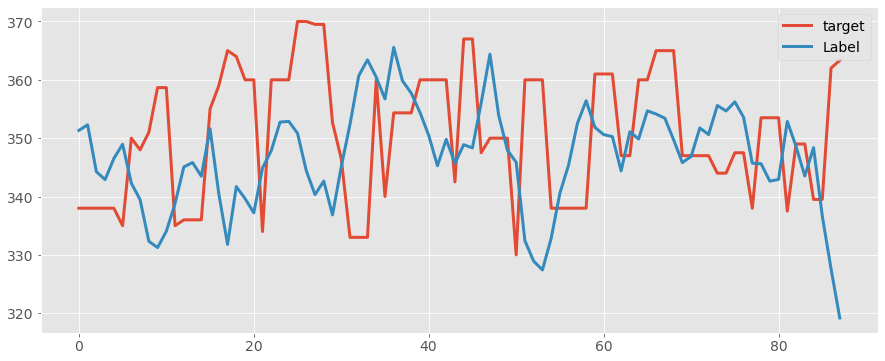

In [58]:
df_test180[df_test180['shoe_size_10']==1][['target','Label']].plot(figsize=(15,6));

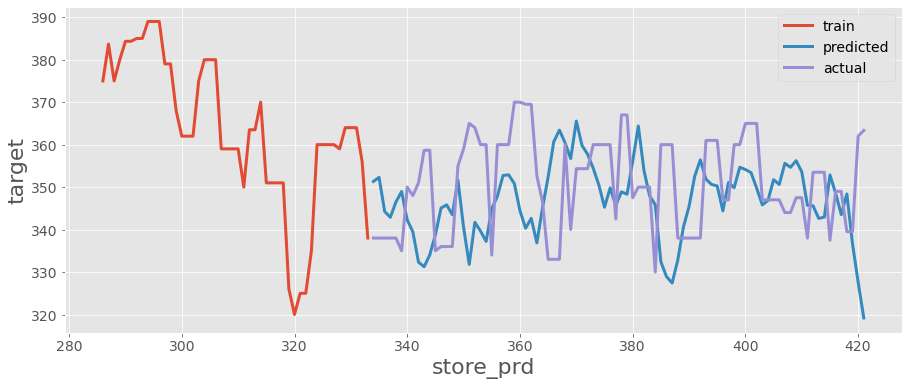

In [59]:
fig, ax = plt.subplots(1, 1, figsize=(15,6))
ax = sns.lineplot(data=train_win180[train_win180['shoe_size_10']==1], x='store_prd', y='target', label='train', ax=ax)
ax = sns.lineplot(data=df_test180[df_test180['shoe_size_10']==1], x='store_prd', y='Label', label='predicted', ax=ax)
ax = sns.lineplot(data=df_test180[df_test180['shoe_size_10']==1], x='store_prd', y='target', label='actual', ax=ax);

#### Extra Trees - MAE 11.1079, RMSE 13.5491, R2 -0.4017

In [60]:
et180 = py180.create_model('et')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,12.8133,325.0504,18.0292,0.4464,0.0522,0.0376
1,8.8708,120.1084,10.9594,0.5057,0.0313,0.0254
2,10.9758,144.5004,12.0208,0.4787,0.0331,0.0302
3,5.2471,59.2816,7.6995,0.5357,0.0206,0.0140
4,4.5792,25.4736,5.0471,0.6589,0.0139,0.0126
5,8.2596,91.2726,9.5537,0.3935,0.0266,0.0226
6,18.0858,367.1425,19.1610,0.3157,0.0545,0.0518
7,12.2258,253.4938,15.9215,0.3213,0.0455,0.0352
8,18.2339,571.3241,23.9024,-0.0602,0.0698,0.0549
9,11.7878,174.1607,13.1970,-7.6123,0.0365,0.0319


In [61]:
tuned_et180 = py180.tune_model(et180, optimize='RMSE', choose_better=True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,14.0339,275.5434,16.5995,0.5307,0.0476,0.0401
1,10.1214,147.0945,12.1283,0.3947,0.0344,0.0288
2,11.3375,147.9653,12.1641,0.4662,0.0338,0.0315
3,7.4509,87.9796,9.3797,0.3110,0.0252,0.0199
4,6.0857,42.3624,6.5086,0.4328,0.0181,0.0169
5,8.4107,72.4633,8.5125,0.5185,0.0232,0.0230
6,16.0333,312.2188,17.6697,0.4180,0.0504,0.0459
7,11.5854,215.8288,14.6911,0.4221,0.0422,0.0334
8,16.0234,451.2028,21.2415,0.1627,0.0625,0.0484
9,10.5440,148.1469,12.1716,-6.3259,0.0337,0.0286


In [62]:
df_val180 = py180.predict_model(et180)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,8.9812,105.8933,10.2904,0.3617,0.0281,0.0241


In [63]:
df_test180 = py180.predict_model(et180, data=test_win180)
df_test180

,shoe_size_10,target,store_frd,store_prd,1,2,3,4,5,6,...,172,173,174,175,176,177,178,179,180,Label
0,1,338.000000,64.0,334.0,362.000000,363.666667,362.000000,360.250000,365.333333,361.000000,...,389.0,386.5,380.0,380.0,380.0,380.0,380.0,392.0,393.000000,346.290
1,1,338.000000,65.0,335.0,363.666667,362.000000,360.250000,365.333333,361.000000,363.400000,...,386.5,380.0,380.0,380.0,380.0,380.0,392.0,393.0,396.000000,347.605
2,1,338.000000,66.0,336.0,362.000000,360.250000,365.333333,361.000000,363.400000,368.000000,...,380.0,380.0,380.0,380.0,380.0,392.0,393.0,396.0,396.000000,343.890
3,1,338.000000,67.0,337.0,360.250000,365.333333,361.000000,363.400000,368.000000,360.000000,...,380.0,380.0,380.0,380.0,392.0,393.0,396.0,396.0,394.000000,347.155
4,1,338.000000,68.0,338.0,365.333333,361.000000,363.400000,368.000000,360.000000,364.200000,...,380.0,380.0,380.0,392.0,393.0,396.0,396.0,394.0,395.666667,347.675
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,1,349.000000,147.0,417.0,392.500000,377.000000,394.333333,397.000000,390.000000,395.000000,...,351.0,326.0,320.0,325.0,325.0,335.0,360.0,360.0,360.000000,348.975
84,1,339.500000,148.0,418.0,377.000000,394.333333,397.000000,390.000000,395.000000,388.333333,...,326.0,320.0,325.0,325.0,335.0,360.0,360.0,360.0,360.000000,349.740
85,1,339.500000,149.0,419.0,394.333333,397.000000,390.000000,395.000000,388.333333,386.000000,...,320.0,325.0,325.0,335.0,360.0,360.0,360.0,360.0,359.000000,348.705
86,1,362.000000,150.0,420.0,397.000000,390.000000,395.000000,388.333333,386.000000,389.750000,...,325.0,325.0,335.0,360.0,360.0,360.0,360.0,359.0,364.000000,342.700


#### Extra Trees - Prediction MAE 10.8647

In [64]:
check_metric(df_test180.target, df_test180.Label, 'MAE')

10.8647

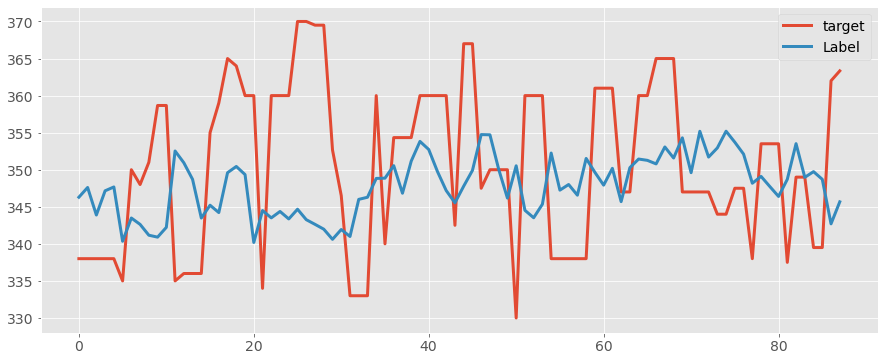

In [65]:
df_test180[df_test180['shoe_size_10']==1][['target','Label']].plot(figsize=(15,6));

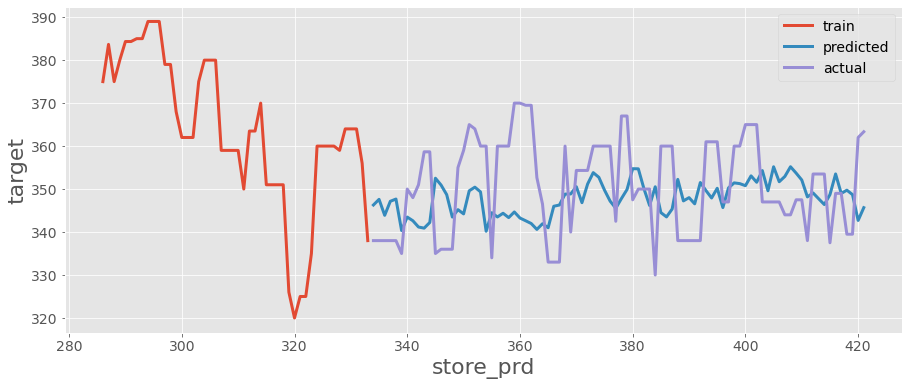

In [66]:
fig, ax = plt.subplots(1, 1, figsize=(15,6))
ax = sns.lineplot(data=train_win180[train_win180['shoe_size_10']==1], x='store_prd', y='target', label='train', ax=ax)
ax = sns.lineplot(data=df_test180[df_test180['shoe_size_10']==1], x='store_prd', y='Label', label='predicted', ax=ax)
ax = sns.lineplot(data=df_test180[df_test180['shoe_size_10']==1], x='store_prd', y='target', label='actual', ax=ax);